# Description

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = conf.RESULTS["GLS_NULL_SIMS"] / "phenoplier"
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier')

# Load MultiXcan genes present in results

In [4]:
_tmp = pd.read_csv(conf.RESULTS["GLS_NULL_SIMS"] / "twas" / "smultixcan" / "random.pheno0-gtex_v8-mashr-smultixcan.txt", sep="\t")

In [5]:
_tmp.shape

(22317, 18)

In [6]:
_tmp.head()

,gene,gene_name,pvalue,n,n_indep,p_i_best,t_i_best,p_i_worst,t_i_worst,eigen_max,eigen_min,eigen_min_kept,z_min,z_max,z_mean,z_sd,tmi,status
0,ENSG00000131941.7,RHPN2,0.000040,48.0,3.0,2.139470e-04,Artery_Tibial,0.990132,Brain_Nucleus_accumbens_basal_ganglia,36.556432,7.692089e-16,2.519701,-2.721185,3.701952,1.283152,1.825567,3.0,0
1,ENSG00000076650.6,GPATCH1,0.000078,40.0,3.0,4.534390e-04,Brain_Cerebellum,0.817384,Brain_Frontal_Cortex_BA9,29.990208,2.086487e-15,1.815203,-3.506853,2.383485,-2.016745,1.715495,3.0,0
2,ENSG00000100906.10,NFKBIA,0.000096,1.0,1.0,9.591208e-05,Brain_Frontal_Cortex_BA9,0.000096,Brain_Frontal_Cortex_BA9,1.000000,1.000000e+00,1.000000,-3.900707,-3.900707,-3.900707,NaN,1.0,0
3,ENSG00000136319.11,TTC5,0.000109,47.0,5.0,1.402826e-03,Brain_Hippocampus,0.961887,Colon_Sigmoid,21.272442,8.142339e-16,0.732606,-3.194069,1.397514,-0.916662,1.068989,5.0,0
4,ENSG00000152990.13,ADGRA3,0.000135,41.0,12.0,3.211289e-07,Heart_Atrial_Appendage,0.653657,Whole_Blood,12.988248,3.499412e-16,0.444682,-5.110605,3.599410,-0.464735,2.316607,12.0,0


In [7]:
multixcan_genes = set(_tmp["gene_name"])
display(len(multixcan_genes))
display(list(multixcan_genes)[:10])

22311

['COL4A3BP',
 'HTR5A',
 'PDCD6IP',
 'CLN8',
 'CTD-3193K9.11',
 'PCDHB9',
 'DEFB1',
 'UBE2E3',
 'RIF1',
 'TSC22D1']

# Load MultiPLIER Z matrix

In [8]:
multiplier_z = pd.read_pickle(conf.MULTIPLIER["MODEL_Z_MATRIX_FILE"])

In [9]:
multiplier_z.shape

(6750, 987)

In [10]:
# keep genes only present in MultiXcan
multiplier_z = multiplier_z.loc[sorted(multixcan_genes.intersection(multiplier_z.index))]

In [11]:
multiplier_z.shape

(6446, 987)

In [12]:
multiplier_z.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
A2M,0.000000,0.000000,0.000000,0.078428,0.0,0.00000,0.000000,0.046772,0.000000,0.011033,...,0.010910,0.000000,0.052869,0.012749,0.0,0.013982,0.152241,0.000000,0.000000,0.108884
AAAS,0.271162,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,1.513337,0.000000,...,0.000000,0.000000,0.000000,0.001385,0.0,0.000000,0.711896,0.030534,0.447105,0.424685
AANAT,0.005099,0.308497,0.028815,0.000000,0.0,0.00000,0.371725,0.000000,0.135238,0.000000,...,0.117163,0.018815,0.000000,0.193142,0.0,0.040401,0.180436,0.000000,0.000000,0.042064
AARS,0.512978,0.000000,0.451285,0.319568,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.006208,0.021274,0.0,0.000000,0.062143,0.000000,0.000000,0.364892
AARS2,1.008157,0.000000,0.197424,0.024832,0.0,0.57081,0.000000,0.228675,0.000000,0.116243,...,0.000000,0.000000,0.153345,0.000000,0.0,0.000000,1.004578,0.014470,0.000000,0.000000


# Functions

In [13]:
def show_prop(data, frac=0.05):
    _pvalue_lt_frac = data[data["pvalue"] < frac]
    return _pvalue_lt_frac.shape[0] / data.shape[0]

In [14]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [15]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [16]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [17]:
def qqplot_unif(results):
    data = results["pvalue"].to_numpy()
    n = data.shape[0]
    uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
    
    observed_data = -np.log10(data)
    expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel("$-\log_{10}$(expected pvalue)")
        ax.set_ylabel("$-\log_{10}$(observed pvalue)")
        ax.set_title("QQ-Plot - Null with MASHR models")

In [18]:
def get_lv_genes(lv_code):
    lv_genes = multiplier_z[lv_code].sort_values(ascending=False)
    lv_obj = LVAnalysis(lv_code)
    return lv_obj.lv_genes.set_index("gene_name").loc[lv_genes.index]

# Set input directory

In [19]:
input_directory = INPUT_DIR / "gls-debug_use_ols"
display(input_directory)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols')

# Get files list

In [20]:
INPUT_FILES = list(input_directory.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [21]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [22]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [23]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [24]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 4)

In [25]:
dfs.head()

,lv,coef,pvalue,phenotype
0,LV1,0.007085,0.284804,random.pheno988
1,LV2,0.016905,0.087406,random.pheno988
2,LV3,-0.009680,0.781394,random.pheno988
3,LV4,-0.012916,0.850054,random.pheno988
4,LV5,0.002446,0.422179,random.pheno988


In [26]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [27]:
show_prop(dfs)

0.060587639311043565

It should be around 0.05. Let's check what happened at individual LVs.

# Summary of mean type I error per LV

In [28]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data["pvalue"], 0.01),
            "5": get_prop(lv_data["pvalue"], 0.05),
            "10": get_prop(lv_data["pvalue"], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [29]:
summary_df.shape

(987, 4)

In [30]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.036,0.064
1,LV10,0.013,0.050,0.084
2,LV100,0.018,0.052,0.098
3,LV101,0.018,0.051,0.096
4,LV102,0.011,0.056,0.100


In [31]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016720,0.060588,0.108664
std,0.007981,0.015704,0.022071
min,0.002000,0.015000,0.032000
25%,0.012000,0.050000,0.095000
50%,0.016000,0.060000,0.108000
75%,0.020000,0.069000,0.122000
max,0.104000,0.158000,0.219000


## LVs with expected type I error

In [96]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(80, 4)

,lv,1,5,10
519,LV567,0.016,0.049,0.097
523,LV570,0.016,0.049,0.084
693,LV723,0.013,0.049,0.107
348,LV412,0.009,0.049,0.100
664,LV698,0.008,0.049,0.092
379,LV440,0.008,0.049,0.092
388,LV449,0.014,0.049,0.093
640,LV676,0.012,0.049,0.094
624,LV661,0.010,0.049,0.112
609,LV648,0.007,0.049,0.087


,lv,1,5,10
61,LV154,0.010,0.051,0.096
70,LV162,0.013,0.051,0.105
917,LV925,0.011,0.051,0.107
15,LV112,0.013,0.051,0.091
934,LV940,0.012,0.051,0.087
3,LV101,0.018,0.051,0.096
976,LV979,0.013,0.051,0.108
227,LV303,0.011,0.051,0.101
347,LV411,0.012,0.051,0.112
358,LV421,0.011,0.051,0.091


## LVs with high type I error

In [98]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(460, 4)

,lv,1,5,10
199,LV279,0.026,0.095,0.150
631,LV668,0.032,0.096,0.166
190,LV270,0.033,0.096,0.163
213,LV291,0.042,0.098,0.141
28,LV124,0.036,0.101,0.150
382,LV443,0.040,0.101,0.134
471,LV523,0.033,0.102,0.171
142,LV227,0.043,0.103,0.144
557,LV600,0.034,0.104,0.181
961,LV965,0.039,0.104,0.155


Many LVs have a mean type I error greater than expected.

LV45 has the largest mean type I error (0.158). Let's take a look at these LVs with poor mean type I errors.

# LVs with high mean type I error

## LV45

In [33]:
lv_code = "LV45"

In [34]:
results = dfs[dfs["lv"] == lv_code]

In [35]:
results.shape

(1000, 4)

In [36]:
results.head()

,lv,coef,pvalue,phenotype
44,LV45,0.005419,0.331794,random.pheno988
1031,LV45,0.001082,0.465395,random.pheno589
2018,LV45,0.000133,0.495730,random.pheno385
3005,LV45,0.007096,0.284506,random.pheno5
3992,LV45,-0.009028,0.765655,random.pheno74


### Mean type I errors at different thresholds

In [37]:
show_prop(results, 0.01)

0.104

In [38]:
show_prop(results, 0.05)

0.158

In [39]:
show_prop(results, 0.10)

0.219

In [40]:
show_prop(results, 0.15)

0.266

In [41]:
show_prop(results, 0.20)

0.292

### QQplot

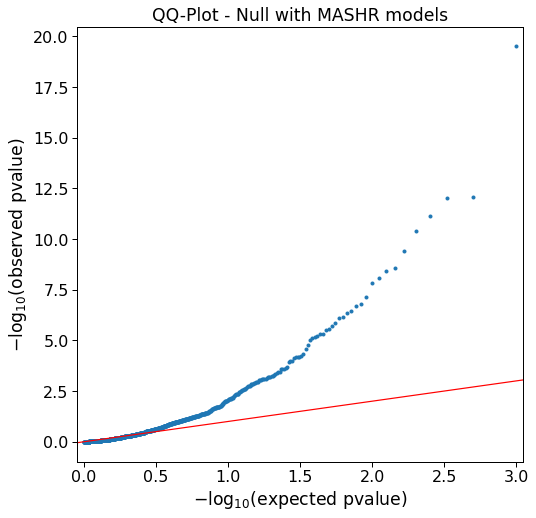

In [42]:
qqplot_unif(results)

### Why mean type I errors are so high?

In [43]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV45,gene_band
HIST1H2BO,8.480948,6p22.1
HIST1H2BF,8.426226,6p22.2
HIST1H2BK,8.245903,6p22.1
HIST1H2BD,8.119013,6p22.2
HIST1H2BC,7.744137,6p22.2
HIST1H2AC,7.447932,6p22.2
HIST2H2BF,6.700409,1q21.2
HIST1H2AG,6.405812,6p22.1
HIST1H2BN,5.913649,6p22.1
HIST1H2AE,5.898213,6p22.2


In [44]:
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2     11
6p22.1      6
1q42.13     2
1q21.2      1
11q23.3     1
1q42.12     1
17q25.1     1
4q23        1
19q13.2     1
17q24.1     0
Name: gene_band, dtype: int64

Top genes in this LV are all from the same band, very likely causing high type I errors.

## LV234

In [45]:
lv_code = "LV234"

In [46]:
results = dfs[dfs["lv"] == lv_code]

In [47]:
results.shape

(1000, 4)

In [48]:
results.head()

,lv,coef,pvalue,phenotype
233,LV234,0.004362,0.363127,random.pheno988
1220,LV234,-0.001422,0.545441,random.pheno589
2207,LV234,0.002184,0.430429,random.pheno385
3194,LV234,0.012870,0.150810,random.pheno5
4181,LV234,0.011771,0.172394,random.pheno74


### Mean type I errors at different thresholds

In [49]:
show_prop(results, 0.01)

0.086

In [50]:
show_prop(results, 0.05)

0.154

In [51]:
show_prop(results, 0.10)

0.209

In [52]:
show_prop(results, 0.15)

0.241

In [53]:
show_prop(results, 0.20)

0.285

### QQplot

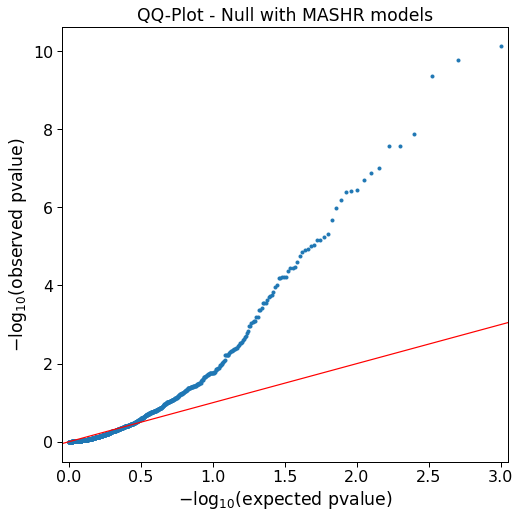

In [54]:
qqplot_unif(results)

### Why mean type I errors are so high?

In [55]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV234,gene_band
HIST1H4E,7.379845,6p22.2
HIST1H3B,7.293635,6p22.2
HIST4H4,6.929394,12p12.3
HIST1H3H,6.863106,6p22.1
HIST1H3D,4.568047,6p22.2
HIST1H2BC,4.078396,6p22.2
HIST1H2AE,4.009782,6p22.2
HIST1H2BF,3.963254,6p22.2
HIST1H2BD,3.862981,6p22.2
HIST1H2BK,3.662444,6p22.1


In [56]:
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2      12
6p22.1       5
12p12.3      1
17q21.31     1
17q25.1      1
1q42.12      1
1q42.13      1
11q23.3      1
4q23         1
16p11.2      1
Name: gene_band, dtype: int64

Same as LV45

## LV847

In [57]:
lv_code = "LV847"

In [58]:
results = dfs[dfs["lv"] == lv_code]

In [59]:
results.shape

(1000, 4)

In [60]:
results.head()

,lv,coef,pvalue,phenotype
846,LV847,-0.004228,0.632824,random.pheno988
1833,LV847,0.001357,0.456628,random.pheno589
2820,LV847,-0.003279,0.603777,random.pheno385
3807,LV847,0.008201,0.255203,random.pheno5
4794,LV847,0.014658,0.119692,random.pheno74


### Mean type I errors at different thresholds

In [61]:
show_prop(results, 0.01)

0.091

In [62]:
show_prop(results, 0.05)

0.143

In [63]:
show_prop(results, 0.10)

0.191

In [64]:
show_prop(results, 0.15)

0.225

In [65]:
show_prop(results, 0.20)

0.264

### QQplot

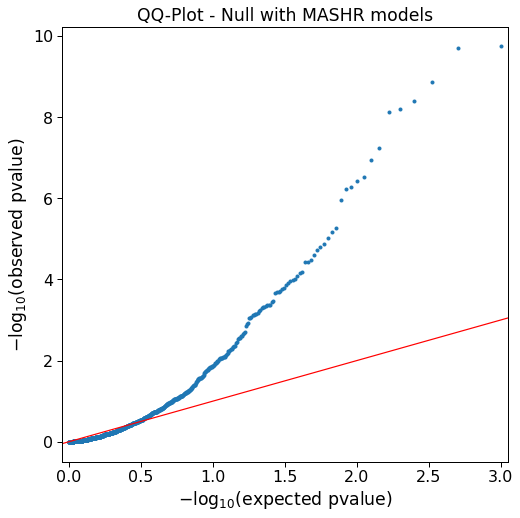

In [66]:
qqplot_unif(results)

### Why mean type I errors are so high?

In [67]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV847,gene_band
HIST1H3D,6.805370,6p22.2
HIST1H3H,6.276783,6p22.1
HIST1H3B,6.099625,6p22.2
HIST1H4E,5.971181,6p22.2
HIST4H4,5.431832,12p12.3
HIST1H2BH,5.150647,6p22.2
HIST1H2AE,4.324334,6p22.2
HIST1H2BN,4.269944,6p22.1
HIST1H2BE,4.258760,6p22.2
HIST1H2AC,4.046811,6p22.2


In [68]:
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2     15
6p22.1      5
1q42.13     2
11q23.3     1
17q25.1     1
12p12.3     1
17q23.2     0
18q12.2     0
18q12.1     0
18q11.2     0
Name: gene_band, dtype: int64

Same as LV45

## LV110

In [69]:
lv_code = "LV110"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 4)

In [72]:
results.head()

,lv,coef,pvalue,phenotype
109,LV110,-0.024160,0.973768,random.pheno988
1096,LV110,0.000731,0.476604,random.pheno589
2083,LV110,-0.005028,0.656726,random.pheno385
3070,LV110,-0.005938,0.683164,random.pheno5
4057,LV110,0.009946,0.212348,random.pheno74


### Mean type I errors at different thresholds

In [73]:
show_prop(results, 0.01)

0.077

In [74]:
show_prop(results, 0.05)

0.127

In [75]:
show_prop(results, 0.10)

0.178

In [76]:
show_prop(results, 0.15)

0.213

In [77]:
show_prop(results, 0.20)

0.249

### QQplot

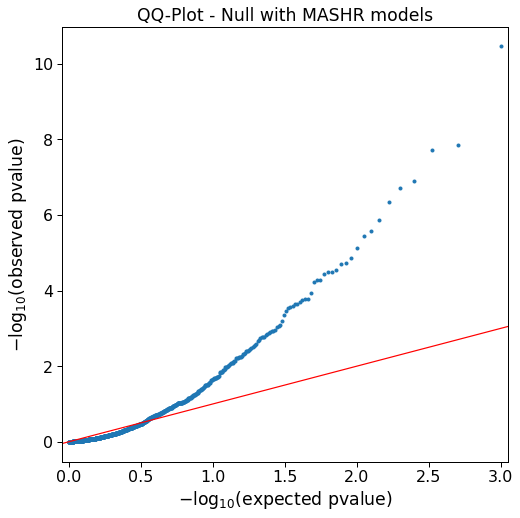

In [78]:
qqplot_unif(results)

### Why mean type I errors are so high?

In [79]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV110,gene_band
HIST1H4D,6.862617,6p22.2
HIST1H2AD,6.425544,6p22.2
HIST1H1E,6.329128,6p22.2
HIST1H1C,5.829177,6p22.2
HIST1H1D,5.497928,6p22.2
HIST1H2BJ,5.265400,6p22.1
HIST1H4I,4.974646,6p22.1
HIST1H2BG,4.786019,6p22.2
HIST1H4H,4.607877,6p22.2
HIST1H2BE,3.079962,6p22.2


In [80]:
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p22.2      12
6p22.1       4
1q42.13      2
16p12.3      1
5q33.1       1
20q13.12     1
3p21.2       1
1p21.1       1
11q23.3      1
3q11.2       1
Name: gene_band, dtype: int64

Same as LV45

## LV769

In [198]:
lv_code = "LV769"

In [199]:
results = dfs[dfs["lv"] == lv_code]

In [200]:
results.shape

(1000, 4)

In [201]:
results.head()

,lv,coef,pvalue,phenotype
768,LV769,0.012389,0.160028,random.pheno988
1755,LV769,0.001512,0.451694,random.pheno589
2742,LV769,0.002059,0.434367,random.pheno385
3729,LV769,-0.021138,0.955120,random.pheno5
4716,LV769,-0.018998,0.936360,random.pheno74


### Mean type I errors at different thresholds

In [202]:
show_prop(results, 0.01)

0.038

In [203]:
show_prop(results, 0.05)

0.12

In [204]:
show_prop(results, 0.10)

0.198

In [205]:
show_prop(results, 0.15)

0.25

In [206]:
show_prop(results, 0.20)

0.307

### QQplot

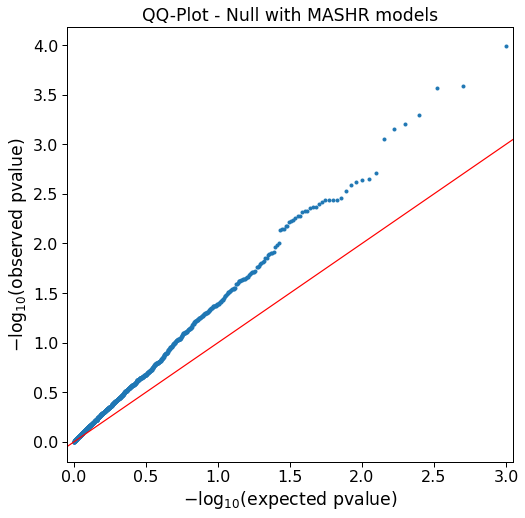

In [207]:
qqplot_unif(results)

### Why mean type I errors are so high?

In [208]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV769,gene_band
RCHY1,4.709602,4q21.1
MICB,4.094715,6p21.33
FAM20B,2.025532,1q25.2
GLUD1,1.944526,10q23.2
SPHK2,1.873681,19q13.33
UBE2T,1.610870,1q32.1
SPDYA,1.517940,2p23.2
CYP26B1,1.394458,2p13.2
MREG,1.239710,2q35
ZNF584,1.126256,19q13.43


Ok, first LV that does not have genes from the same band at the top. What's going on here?

In [209]:
lv_genes.head(25)["gene_band"].value_counts().head(10)

6p21.33    2
7q36.1     2
4q13.3     1
8q21.13    1
9p13.2     1
2p23.2     1
5q31.1     1
4q21.1     1
2q11.2     1
1q25.2     1
Name: gene_band, dtype: int64

There are same genes from the same band at the top, but not that many as the other LVs.
**However**, top genes from chr 6 are here. Those might be highly correlated.

What happens if I take a look at more top genes?

In [210]:
lv_genes.head(50)["gene_band"].value_counts().head(5)

7q36.1      2
6p21.33     2
5q31.1      2
20q13.33    1
8q21.13     1
Name: gene_band, dtype: int64

In [211]:
lv_genes.head(100)["gene_band"].value_counts().head(15)

5q31.1      3
1p22.3      3
4q13.3      2
4p14        2
4q21.1      2
7q36.1      2
11q13.2     2
1q21.3      2
8q21.3      2
10q26.13    2
6p21.33     2
20q11.22    2
4q25        1
12q13.12    1
14q21.3     1
Name: gene_band, dtype: int64

In [212]:
lv_genes.head(150)["gene_band"].value_counts().head(20)

1p22.3      3
1q21.3      3
5q31.1      3
10q26.13    2
1p36.11     2
8p22        2
8q21.3      2
4p14        2
2q35        2
4q13.3      2
4q21.1      2
7q36.1      2
11q13.2     2
14q24.1     2
17q12       2
14q11.2     2
20q11.22    2
6p21.33     2
12q24.33    2
4p15.2      1
Name: gene_band, dtype: int64

In [213]:
lv_genes.head(200)["gene_band"].value_counts().head(30)

1q21.3      3
1p22.3      3
16q22.1     3
12q24.33    3
5q31.1      3
10q26.13    2
4q13.3      2
19q13.2     2
19p13.2     2
8q22.3      2
8q22.1      2
8q21.3      2
2q24.1      2
4p14        2
10q24.32    2
14q24.1     2
18q21.1     2
3q26.31     2
8p22        2
2q35        2
6q13        2
7q31.2      2
7q36.1      2
11p15.4     2
11q13.2     2
4q21.1      2
17q12       2
1p36.11     2
14q11.2     2
20q11.22    2
Name: gene_band, dtype: int64

## Distribution of gene weights

In [214]:
lv_genes[lv_code].describe()

count    6446.000000
mean        0.031280
std         0.122941
min         0.000000
25%         0.000000
50%         0.000000
75%         0.023323
max         4.709602
Name: LV769, dtype: float64

In [215]:
lv_genes[lv_code].quantile(np.arange(0.80, 1.0, 0.01))

0.80    0.036859
0.81    0.040913
0.82    0.044273
0.83    0.047017
0.84    0.051144
0.85    0.055721
0.86    0.058959
0.87    0.063310
0.88    0.069273
0.89    0.075060
0.90    0.081388
0.91    0.089863
0.92    0.098529
0.93    0.107157
0.94    0.120829
0.95    0.135075
0.96    0.157527
0.97    0.200097
0.98    0.260205
0.99    0.395757
Name: LV769, dtype: float64

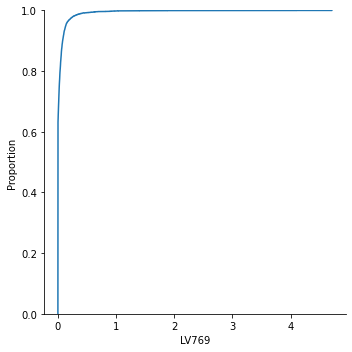

In [216]:
sns.displot(data=lv_genes, x=lv_code, kind="ecdf")

(-0.05, 0.5)

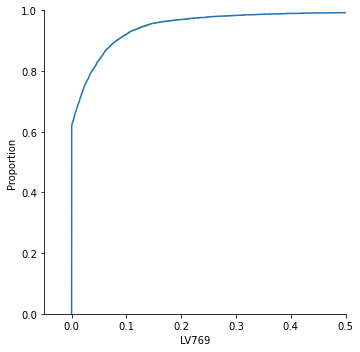

In [217]:
g = sns.displot(data=lv_genes, x=lv_code, kind="ecdf")
g.ax.set_xlim((-0.05, 0.50))

How does band number patterns and distribution of weights in this LV compare with LVs with expected mean type I error?

In [218]:
lv769_genes = lv_genes

# LVs with expected mean type I error

In [219]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
519,LV567,0.016,0.049,0.097
523,LV570,0.016,0.049,0.084
693,LV723,0.013,0.049,0.107
348,LV412,0.009,0.049,0.100
664,LV698,0.008,0.049,0.092
379,LV440,0.008,0.049,0.092
388,LV449,0.014,0.049,0.093
640,LV676,0.012,0.049,0.094
624,LV661,0.010,0.049,0.112
609,LV648,0.007,0.049,0.087


## LV412

In [220]:
lv_code = "LV412"

In [221]:
results = dfs[dfs["lv"] == lv_code]

In [222]:
results.shape

(1000, 4)

In [223]:
results.head()

,lv,coef,pvalue,phenotype
411,LV412,-0.010372,0.797435,random.pheno988
1398,LV412,-0.015866,0.898571,random.pheno589
2385,LV412,0.019627,0.057581,random.pheno385
3372,LV412,0.009720,0.217653,random.pheno5
4359,LV412,0.010105,0.208680,random.pheno74


### Mean type I errors at different thresholds

In [224]:
show_prop(results, 0.01)

0.009

In [225]:
show_prop(results, 0.05)

0.049

In [226]:
show_prop(results, 0.10)

0.1

In [227]:
show_prop(results, 0.15)

0.141

In [228]:
show_prop(results, 0.20)

0.187

### QQplot

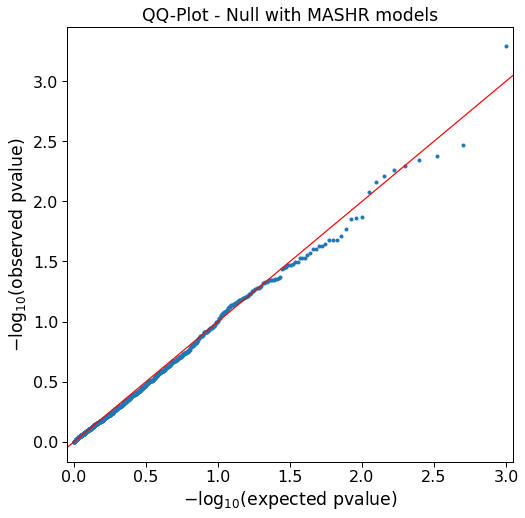

In [229]:
qqplot_unif(results)

### Why mean type I errors are expected?

In [233]:
lv_genes = get_lv_genes(lv_code)
display(lv_genes.head(25))

,LV412,gene_band
KCNH8,5.521022,3p24.3
ZNF135,3.878779,19q13.43
ZNF614,3.775552,19q13.41
ZNF606,2.929764,19q13.43
PANK1,2.749045,10q23.31
ABCB9,2.445773,12q24.31
ZNF443,2.197429,19p13.2
ZNF649,1.970191,19q13.41
SKIV2L,1.735204,6p21.33
CLCN3,1.721717,4q33


In [234]:
lv_genes.head(25)["gene_band"].value_counts().head(10)

19q13.41    2
19q13.43    2
1p36.12     1
1q41        1
8q24.3      1
17p11.2     1
17q12       1
6p21.33     1
2q31.1      1
6p24.1      1
Name: gene_band, dtype: int64

Not different than LV759 at the top 25 genes in terms of numbers of genes from the same band.
**However**, we don't have genes from the same band in chr 6 here.

Let's keep looking:

In [235]:
lv_genes.head(50)["gene_band"].value_counts().head(5)

12q24.31    2
19q13.43    2
19q13.41    2
8q24.3      1
1q22        1
Name: gene_band, dtype: int64

No difference with LV769

In [236]:
lv_genes.head(100)["gene_band"].value_counts().head(15)

19q13.41    3
12q24.31    3
19q13.12    3
19q13.43    3
2p25.1      2
1q41        2
14q24.2     2
1q22        2
16q22.1     2
12q23.1     1
13q14.2     1
13q13.3     1
3p21.31     1
19p13.11    1
1p35.2      1
Name: gene_band, dtype: int64

No big difference with LV769

In [237]:
lv_genes.head(150)["gene_band"].value_counts().head(20)

16q22.1     4
19q13.43    3
19q13.41    3
1q41        3
19q13.12    3
1q22        3
12q24.31    3
11q13.2     2
19p13.2     2
5q32        2
15q14       2
13q14.2     2
6q21        2
2p25.1      2
6p21.1      2
3p25.1      2
11q23.1     2
14q24.2     2
7q11.21     1
1p34.1      1
Name: gene_band, dtype: int64

No big difference with LV769.

In [238]:
lv_genes.head(200)["gene_band"].value_counts().head(30)

16q22.1     4
12q24.31    4
19q13.41    3
19p13.2     3
1q41        3
19q13.12    3
19q13.43    3
6q21        3
1q22        3
3p21.31     3
1q21.3      2
2q33.1      2
5q32        2
9p21.1      2
7p22.1      2
15q14       2
11q13.2     2
5q23.2      2
13q14.2     2
3p25.1      2
6p21.1      2
5q35.3      2
21q22.3     2
14q24.2     2
2p25.1      2
17q12       2
2p16.1      2
12q13.13    2
1p13.2      2
11q23.1     2
Name: gene_band, dtype: int64

Here there are even more regions repeated, although we are looking at the top 200 genes now.

## Distribution of gene weights

In [239]:
lv_genes[lv_code].describe()

count    6446.000000
mean        0.037322
std         0.151258
min         0.000000
25%         0.000000
50%         0.000000
75%         0.030287
max         5.521022
Name: LV412, dtype: float64

In [240]:
lv_genes[lv_code].quantile(np.arange(0.80, 1.0, 0.01))

0.80    0.043020
0.81    0.045727
0.82    0.049013
0.83    0.052441
0.84    0.056593
0.85    0.061172
0.86    0.065933
0.87    0.072219
0.88    0.077499
0.89    0.083129
0.90    0.090102
0.91    0.099516
0.92    0.110169
0.93    0.122677
0.94    0.138123
0.95    0.156269
0.96    0.184728
0.97    0.225738
0.98    0.293448
0.99    0.432566
Name: LV412, dtype: float64

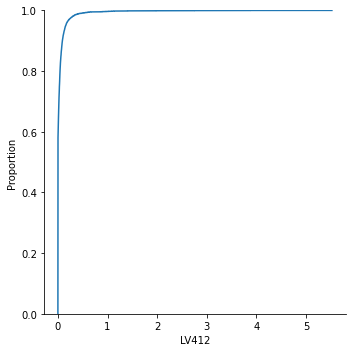

In [241]:
sns.displot(data=lv_genes, x=lv_code, kind="ecdf")

(-0.05, 0.5)

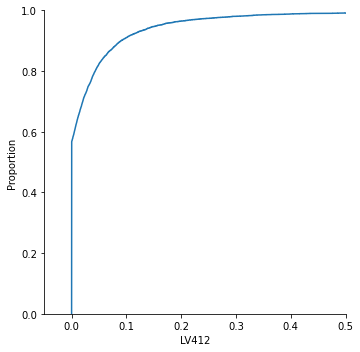

In [242]:
g = sns.displot(data=lv_genes, x=lv_code, kind="ecdf")
g.ax.set_xlim((-0.05, 0.50))

/opt/conda/envs/phenoplier/lib/python3.8/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


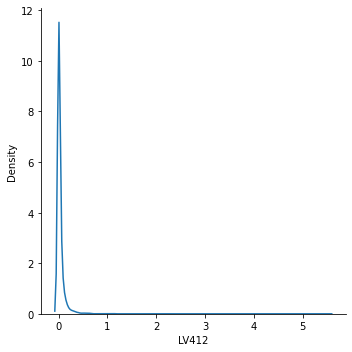

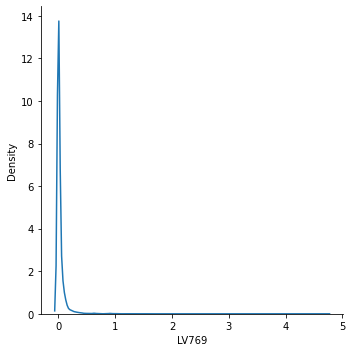

In [250]:
g = sns.displot(x=lv_genes[lv_code], kind="kde")
g = sns.displot(x=lv769_genes["LV769"], kind="kde", ax=g.ax)
# g.ax.set_xlim((-0.05, 0.50))
# g.ax.set_ylim((-0.05, 0.50))

(-0.05, 0.5)

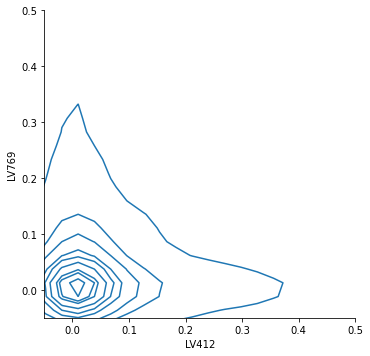

In [246]:
g = sns.displot(x=lv_genes[lv_code], y=lv769_genes["LV769"], kind="kde")
g.ax.set_xlim((-0.05, 0.50))
g.ax.set_ylim((-0.05, 0.50))

DE ESTE GRAFICO parece que ambos LVs abarcan genes totalmente diferentes (los que tienen weight de cero en uno tienen weights altos en el otro).

In [ ]:
POR CADA LV, CONTAR CUANTOS genes tienen weight cero

LUEGO, armar un displot de los genes que tienen valores mayores a cero

una hipotesis es que quizá LV769 (el que da mal) es sparce, y el otro (LV412) es mas dense (tiene valores positivos para mas genes)